# Comparison of data approximation using second and third degree polynomials with scipy.optimize.curve_fit and numpy.polyfit functions

In [110]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Number of points
N_NUM = 100

# Coefficient used to see the polynome behaviour outside of fitting range
SCALE_FACTOR = 1.8

# Percentage of the y range as noise
NOISE_PCT = 0.1 # 0.05 is 5%, 0.10 is 10%

# Borders for cofficients generation
LEFT_BORDER = -10000
RIGHT_BORDER = 10000

# Borders for x values generation
X_LEFT_BORDER = -2000
X_RIGHT_BORDER = 2000

## Objective and Tasks

To translate the prototype code written in Python into production code in C++, it is necessary to write functions that perform data approximation. Currently, the code uses `polyfit` from the `numpy` library for polynomial data approximation. Simultaneously, the code employs the `curve_fit` function from the `scipy` library for data approximation with a custom-defined function. It is necessary to verify whether the `curve_fit` function from the `scipy` library can be used for polynomial approximation instead of `polyfit` from the `numpy` library. This would reduce the number of libraries used and, more importantly, decrease the effort required to write custom functions in C++ because it would involve learning only one library instead of two.

**Objective** - Determine whether it is possible to replace the `numpy.polyfit` function with `scipy.optimize.curve_fit`.

**Tasks**
1. Verify if the polynomial coefficients obtained using `scipy.optimize.curve_fit` and `numpy.polyfit` are equal.
2. Check how close the approximations obtained using `scipy.optimize.curve_fit` and `numpy.polyfit` are to the original polynomial.
3. Assess how close the approximations obtained using `scipy.optimize.curve_fit` and `numpy.polyfit` are to each other.

## Preparation

In [114]:
# Defining polynomial functions for curve fitting
def polynomial_2(x, a0, a1, a2):
    return a0 + a1 * x + a2 * x ** 2

def polynomial_3(x, a0, a1, a2, a3):
    return a0 + a1 * x + a2 * x ** 2 + a3 * x ** 3

def make_poly_title(coeffs, powers):
    terms = []
    for coeff, power in zip(coeffs[::-1], powers[::-1]):
        if power == 0:
            terms.append(f"{coeff:.0f}")
        elif power == 1:
            terms.append(f"{coeff:.0f}*x")
        else:
            terms.append(f"{coeff:.0f}*x**{power}")
    title = "y = " + " + ".join(terms)
    return title.replace("+-", "- ")

def compare(max_power, verbose=True):
    if max_power not in [2, 3]:
        raise ValueError('Invalid max_power for polynomial. Should be 2 or 3')

    # Generating x values
    x = np.linspace(X_LEFT_BORDER, X_RIGHT_BORDER, N_NUM)
    # x values used to see the polynome behaviour outside of fitting range
    x_broad = np.linspace(X_LEFT_BORDER * SCALE_FACTOR,
                          X_RIGHT_BORDER * SCALE_FACTOR,
                          N_NUM)
    x_min = x.min()

    # Generating random coefficients for the polynomial
    coeffs = np.random.randint(LEFT_BORDER, RIGHT_BORDER, max_power + 1)

    # Calculating y values based on the polynomial
    powers = np.arange(max_power, -1, -1)
    if max_power == 2:
        y = polynomial_2(x, *coeffs)
        y_broad = polynomial_2(x_broad, *coeffs)
    else:  # max_power == 3
        y = polynomial_3(x, *coeffs)
        y_broad = polynomial_3(x_broad, *coeffs)

    # Generating noise
    y_max = y.max()
    y_min = y.min()
    noise = np.random.normal(0, 1, N_NUM) * (y_max - y_min) * NOISE_PCT
    # Noisy data
    y_noisy = y + noise

    # Using np.polyfit to fit a polynomial to the noisy data
    coeff_polyfit = np.polyfit(x, y_noisy, max_power)  # Polynomial coefficients, highest power first
    y_polyfit = np.polyval(coeff_polyfit, x_broad) # for plots with broadened x

    # Using scipy.optimize.curve_fit to fit a polynomial to the noisy data
    if max_power == 2:
        coeff_curve_fit, _ = curve_fit(polynomial_2, x, y_noisy)
        y_curve_fit = polynomial_2(x_broad, *coeff_curve_fit) # for plots with broadened x
    else:  # max_power == 3
        coeff_curve_fit, _ = curve_fit(polynomial_3, x, y_noisy)
        y_curve_fit = polynomial_3(x_broad, *coeff_curve_fit) # for plots with broadened x

    if verbose:
        # Plotting the original curve
        plt.plot(x_broad, y_broad, color='grey',
                 label='Original polynomial:\n' + make_poly_title(coeffs, powers))
        # Plotting the noisy data
        plt.scatter(x, y_noisy, color='blue', label='Noisy data', alpha=0.5)
        # Labeling the axes
        plt.xlabel('x')
        plt.ylabel('y')

        # Plotting the fitted polynomials
        plt.plot(x_broad, y_polyfit, color='red', linestyle='--',
                 label='Fitted polynomial (np.polyfit)')
        plt.plot(x_broad, y_curve_fit, color='green', linestyle='--',
                 label='Fitted polynomial (scipy.optimize.curve_fit)')
        plt.legend()

        # Showing the plot
        plt.show()

    # Printing the coefficients
    print("Original coefficients (highest power first): ", coeffs)
    print("Coefficients from np.polyfit: ", coeff_polyfit)
    print("Coefficients from scipy.optimize.curve_fit: ", coeff_curve_fit[::-1])
    # Printing the r2 scores
    print("R2 original vs np.polyfit", r2_score(y_broad, y_polyfit))
    print("R2 original vs scipy.optimize.curve_fit", r2_score(y_broad, y_curve_fit))
    print("R2 np.polyfit vs scipy.optimize.curve_fit", r2_score(y_polyfit, y_curve_fit))

    output = {
        'original': coeffs,
        'polyfit': coeff_polyfit,
        'curve_fit': coeff_curve_fit
    }

    return output


## 3-rd degree polinomial

C:\Users\mxter\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


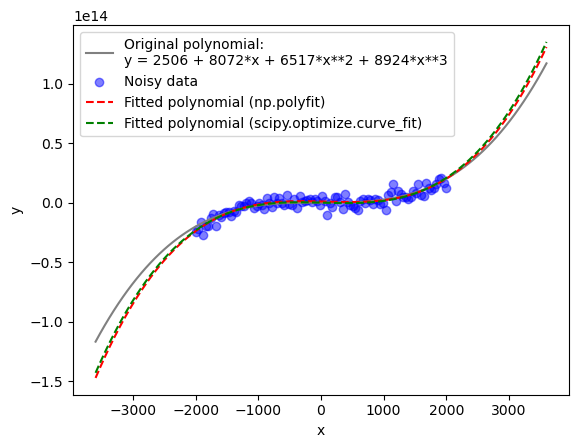

Original coefficients (highest power first):  [8924 6517 8072 2506]
Coefficients from np.polyfit:  [ 3.08200865e+03 -7.15020066e+05 -1.32631369e+09  9.99356129e+11]
Coefficients from scipy.optimize.curve_fit:  [ 3.08200871e+03 -3.06812743e+05 -1.32631385e+09  1.00000000e+00]
R2 original vs np.polyfit 0.9629698787150122
R2 original vs scipy.optimize.curve_fit 0.9675247030820231
R2 np.polyfit vs scipy.optimize.curve_fit 0.9988732993371677
----------------------------------------------------------------------------------------------------


C:\Users\mxter\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


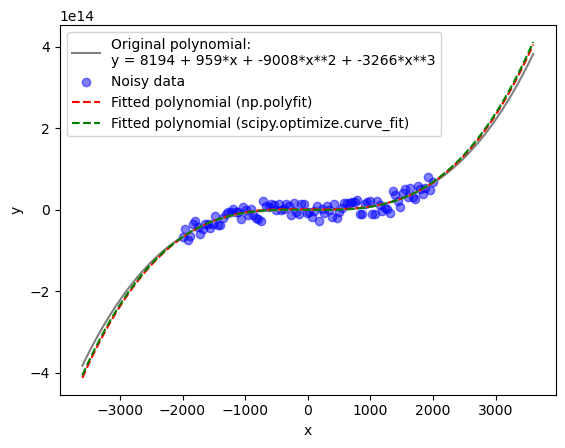

Original coefficients (highest power first):  [-3266 -9008   959  8194]
Coefficients from np.polyfit:  [ 8.90146519e+03 -3.80165639e+05 -1.81402084e+09  1.50349702e+12]
Coefficients from scipy.optimize.curve_fit:  [ 8.90146509e+03  2.33968407e+05 -1.81402055e+09  1.00000000e+00]
R2 original vs np.polyfit 0.9958367510131966
R2 original vs scipy.optimize.curve_fit 0.9958543288908127
R2 np.polyfit vs scipy.optimize.curve_fit 0.9997082130779643
----------------------------------------------------------------------------------------------------


C:\Users\mxter\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


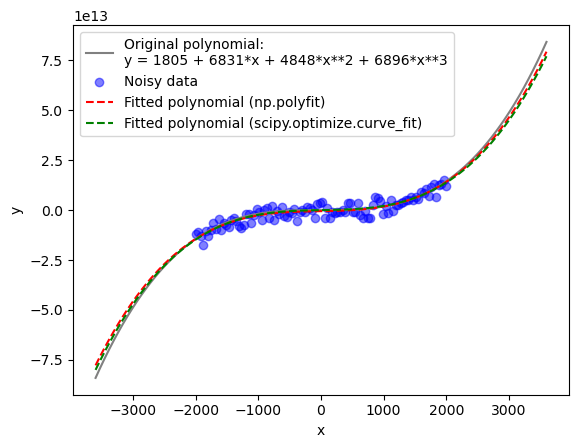

Original coefficients (highest power first):  [6896 4848 6831 1805]
Coefficients from np.polyfit:  [ 1.64022370e+03  1.01717968e+05  5.79443191e+08 -5.30686964e+11]
Coefficients from scipy.optimize.curve_fit:  [ 1.64022368e+03 -1.15051911e+05  5.79443257e+08  1.00000000e+00]
R2 original vs np.polyfit 0.9963561881240409
R2 original vs scipy.optimize.curve_fit 0.9960150896675645
R2 np.polyfit vs scipy.optimize.curve_fit 0.9990478755989618
----------------------------------------------------------------------------------------------------


In [115]:
# Let's try 3 times
for _ in range(3):
    compare(max_power=3, verbose=True)
    print('-'*100)

## 2-nd degree polinomial

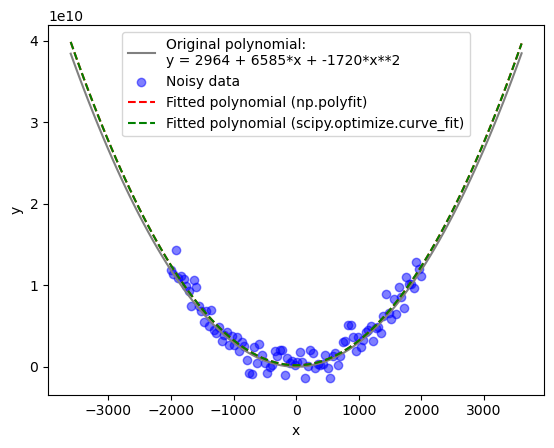

Original coefficients (highest power first):  [-1720  6585  2964]
Coefficients from np.polyfit:  [ 3.05199388e+03 -2.61612291e+04  1.81118503e+08]
Coefficients from scipy.optimize.curve_fit:  [ 3.05199387e+03 -2.61612197e+04  1.81118526e+08]
R2 original vs np.polyfit 0.9967122874734469
R2 original vs scipy.optimize.curve_fit 0.9967122879199911
R2 np.polyfit vs scipy.optimize.curve_fit 1.0
----------------------------------------------------------------------------------------------------


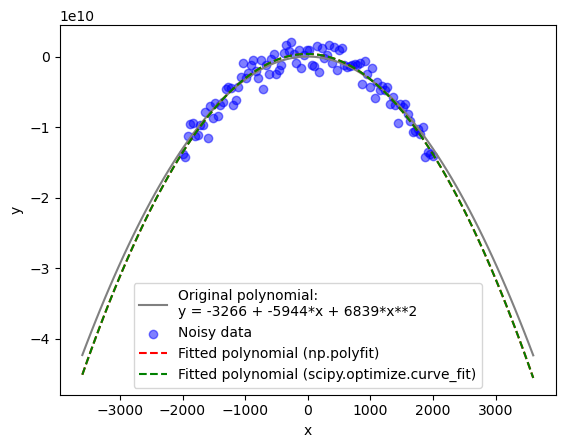

Original coefficients (highest power first):  [ 6839 -5944 -3266]
Coefficients from np.polyfit:  [-3.52580718e+03 -6.30872869e+04  3.71282501e+08]
Coefficients from scipy.optimize.curve_fit:  [-3.52580718e+03 -6.30872587e+04  3.71282515e+08]
R2 original vs np.polyfit 0.989971952862641
R2 original vs scipy.optimize.curve_fit 0.9899719525588241
R2 np.polyfit vs scipy.optimize.curve_fit 1.0
----------------------------------------------------------------------------------------------------


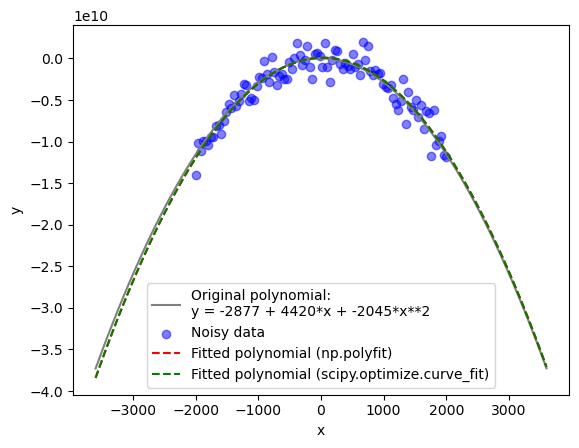

Original coefficients (highest power first):  [-2045  4420 -2877]
Coefficients from np.polyfit:  [-2.92018408e+03  1.84362053e+05  8.38203610e+07]
Coefficients from scipy.optimize.curve_fit:  [-2.92018407e+03  1.84362039e+05  8.38203294e+07]
R2 original vs np.polyfit 0.9985766555986547
R2 original vs scipy.optimize.curve_fit 0.9985766559428566
R2 np.polyfit vs scipy.optimize.curve_fit 1.0
----------------------------------------------------------------------------------------------------


In [116]:
# Let's try 3 times
for _ in range(3):
    compare(max_power=2, verbose=True)
    print('-'*100)

## Conclusions

1. The coefficients of the third-degree polynomials obtained using the `scipy.optimize.curve_fit` and `numpy.polyfit` functions are different.
2. The coefficients of the second-degree polynomials obtained using the `scipy.optimize.curve_fit` and `numpy.polyfit` functions are nearly identical.
3. As seen from the graphs, in the vicinity of the \( X \) values where noisy data was provided, the `scipy.optimize.curve_fit` and `numpy.polyfit` functions give equally good approximations to the original polynomial.
4. As observed from the graphs and the \( R^2 \) values, the approximations provided by the `scipy.optimize.curve_fit` and `numpy.polyfit` functions are closer to each other than to the original polynomial.
5. From points 2-4, it follows that in terms of the result, the use of these functions is equivalent. Therefore, for polynomial data approximation, **the `numpy.polyfit` function can be safely replaced in the code with `scipy.optimize.curve_fit`**.